In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import optimizers, callbacks, layers
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input, Reshape, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)

def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def decay(epochs):
    init = 1e-3
    drop = 10
    ratio = 0.9
    return max(5e-5, (init * (ratio ** (epochs//drop))))

es = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lrs = callbacks.LearningRateScheduler(decay, verbose=0)


In [3]:
def ConvBlock(n, kernel_size=3, strides=2, bn=True, activation=mish, padding='same'):
    def f(x):
        x = Conv2D(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(activation)(x)         
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def deConvBlock(n, kernel_size=3, strides=2, bn=True, activation=mish, padding='same'):
    def f(x):
        x = Conv2DTranspose(n, kernel_size=kernel_size, strides=strides, padding=padding)(x)
        x = Activation(activation)(x)       
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    return f

def sampler(batch_size, z_dim=100):
    return tf.random.normal(shape=(batch_size, z_dim))

In [4]:
class GAN(keras.Model):
    def __init__(self, d_shape, z_dim):
        super(GAN, self).__init__()
        self.d_shape = d_shape
        self.z_dim = z_dim
        
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
    
    def compile(self, g_optim, d_optim, loss_fn):
        super(GAN, self).compile()
        self.g_optim = g_optim
        self.d_optim = d_optim
        self.loss_fn = loss_fn
        
    def build_generator(self):
        inputs = Input(shape = (self.z_dim, ))
        
        x = Dense(128*7*7, activation='relu')(inputs)
        x = Reshape((7, 7, 128))(x) # 7, ,7 128
        x = BatchNormalization(momentum=0.8)(x)
        x = deConvBlock(64)(x) # 14, 14, 64
        x = deConvBlock(32)(x) # 28, 28, 32
        
        outputs = Conv2D(1, kernel_size=3, strides=1, activation='tanh', padding='same')(x) # 28, 28, 1
        
        gen = Model(inputs, outputs, name='generator')
        
        return gen
    
    def build_discriminator(self):
        inputs = Input(shape = self.d_shape)
        
        x = ConvBlock(16)(inputs)
        x = ConvBlock(32)(x)
        x = ConvBlock(64)(x)
        x = Flatten()(x)
        
        outputs = Dense(1, activation='sigmoid')(x)
        
        disc = Model(inputs, outputs, name='discriminator')
        
        return disc
    
    def train_step(self, x):
        batch_size = tf.shape(x)[0]
        
        noise = sampler(batch_size)
        
        fake_x = self.generator(noise)
        all_x = tf.concat([fake_x, x], 0)
        
        fake_labels = tf.ones((batch_size, 1))*0
        real_labels = tf.ones((batch_size, 1))
        labels = tf.concat([fake_labels, real_labels], 0)
        
        # keras official tutorial saids add noise to label is important trick
        # labels = 0.05*tf.random.uniform(tf.shape(labels))
        
        # disc / gen alternatively
        with tf.GradientTape() as tape:
            preds = self.discriminator(all_x)
            d_loss = self.loss_fn(labels, preds)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optim.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        with tf.GradientTape() as tape:
            preds = self.discriminator(self.generator(noise))
            g_loss = self.loss_fn(real_labels, preds)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optim.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {'d_loss': d_loss, 'g_loss': g_loss}


In [5]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
X = np.concatenate([x_train, x_test])
X = X.astype("float32") / 127.5 - 1
X = np.expand_dims(X, -1)

X.shape
# tf.data 공부하고 추가 적용하기
# batch_size = 32
# data = tf.data.Dataset.from_tensor_slices(X)
# data = data.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

(70000, 28, 28, 1)

In [6]:
# Check list
## model architecture ~ for images or complicated data, carefully design
## use callbacks to check training progress
gan = GAN(X.shape[1:], 100)

In [7]:
gan.generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        25

In [8]:
gan.discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
activation_3 (Activation)    (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 32)        

In [9]:
class ImageCallback(callbacks.Callback):
    def __init__(self):
        pass
        
    def on_epoch_end(self, epoch, losg=None):
        noise = sampler(1)
        
        fig = plt.figure(figsize=(1, 1))
        gen_img = self.model.generator.predict(noise)
        gen_img = np.squeeze(gen_img)
        plt.imshow(gen_img, cmap='gray')
        plt.show()
        

Epoch 1/5
2188/2188 [==============================] - ETA: 0s - d_loss: 0.4859 - g_loss: 1.4685

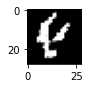

2188/2188 [==============================] - 21s 9ms/step - d_loss: 0.4858 - g_loss: 1.4686
Epoch 2/5
2186/2188 [============================>.] - ETA: 0s - d_loss: 0.5855 - g_loss: 1.0949

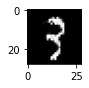

2188/2188 [==============================] - 21s 9ms/step - d_loss: 0.5854 - g_loss: 1.0947
Epoch 3/5
2185/2188 [============================>.] - ETA: 0s - d_loss: 0.6082 - g_loss: 0.9507

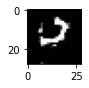

2188/2188 [==============================] - 21s 10ms/step - d_loss: 0.6083 - g_loss: 0.9505
Epoch 4/5
2184/2188 [============================>.] - ETA: 0s - d_loss: 0.6208 - g_loss: 0.9283

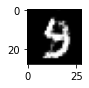

2188/2188 [==============================] - 21s 10ms/step - d_loss: 0.6208 - g_loss: 0.9284
Epoch 5/5
2183/2188 [============================>.] - ETA: 0s - d_loss: 0.6184 - g_loss: 0.9243

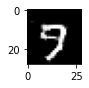

2188/2188 [==============================] - 20s 9ms/step - d_loss: 0.6185 - g_loss: 0.9243


In [10]:
gan.compile(
    optimizers.Adam(2e-4),
    optimizers.Adam(2e-4),
    keras.losses.BinaryCrossentropy()
           )

gan.fit(X, epochs=5,
       callbacks = [ImageCallback()])
